In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
def readDBabse(nclass,fname,n5):
    with nc.Dataset(fname) as fh:
        zkum=fh.variables["zkum%2.2i"%(nclass)][:,:-n5]
        zkam=fh.variables["zkam%2.2i"%(nclass)][:,:-n5]
        pRate=fh.variables["pRate%2.2i"%(nclass)][:,:-n5]
        pRate=fh.variables["pRate%2.2i"%(nclass)][:,:-n5]
        n52=int(n5/2)
        pRateCMB=fh.variables["pRateCMB%2.2i"%(nclass)][:,:-n52]
    zkum[zkum<0]=0
    FL=168+2*nclass
    return zkum,zkam,pRate,pRateCMB,FL

fnameO="stratiformProfilesOcean.nc"
fnameL="stratiformProfiles_2.nc"

ncl=-5

zkumO,zkamO,pRateO,pRateCMBO,FL_O=readDBabse(ncl,fnameL,6)

#plt.plot(zkumO.mean(axis=0))

In [2]:
zkumO[0,77]
import matplotlib.pyplot as plt
h=np.arange(zkumO.shape[1])+2*ncl-70
print(pRateCMBO.shape)
print(h[::2].shape)
pRateCMBOResampled=np.interp(h[0:78],h[0::2][:-1],pRateCMBO.mean(axis=0)[:-1])
#plt.plot(pRateO.mean(axis=0)[0:78],h[0:78])
#plt.plot(pRateCMBO.mean(axis=0),h[0::2])
#plt.plot(pRateCMBOResampled,h[0:78])
#plt.xlim(0,2)
#plt.ylim(40,-40)


(81057, 40)
(40,)


In [3]:
xL=[]
yL=[]
corrCoefL=[]
relBiasL=[]
biasL=[]
clut_unrolled_L=[]
pRateL_all=[]
pRateLL_all=[]
classL=[]
npoints=25
corrFact=np.loadtxt("corrFact.txt")
np.random.seed(1969)
for ncl in range(-5,13):
    print(ncl)
    zkumO,zkamO,pRateO,pRateCMBO,FL_O=readDBabse(ncl,fnameL,6)
    zkumO=zkumO[:,:78]
    pRateO=pRateO[:,:78]   
    pRateCMBO=pRateCMBO[:,:39] 
    h=np.arange(zkumO.shape[1])+2*ncl-70
    zmL=[]
    hL=[]
    pRateL=[]
    pRateLL=[]
    indL=[]
    clutL=[]
    
    for it in range(1):
        for i,zkum in enumerate(zkumO):
            k=np.random.randint(0,25)
            nlev_end=k+1
            nlev_start=nlev_end+npoints
            hL.append(h[-nlev_start:-nlev_end])
            zmL.append(zkum[-nlev_start:-nlev_end])
            pRateCMBO_Resampled=np.interp(h[0:78],h[0::2][:-1],pRateCMBO[i,:][:-1])
            pRateLL.append(pRateCMBO_Resampled[-nlev_end-1])
            pRateL.append(pRateCMBO_Resampled[-1])
            x1=[]
            x1.extend(zmL[-1])
            x1.extend(hL[-1][-1:])
            x1.append(h[-1])
            x1.append(pRateLL[-1])
            x1.append(pRateLL[-1]*corrFact[ncl+5,k])
            yL.append(pRateL[-1])
            indL.append(h[-1])
            clutL.append(k)
            xL.append(x1)
            classL.append(ncl)
    pRateLL=np.array(pRateLL)
    pRateL=np.array(pRateL)
    pRateL_all.extend(pRateL)
    pRateLL_all.extend(pRateLL)
    clutL=np.array(clutL)
    corrCoef=[]
    relBias=[]
    bias=[]
    clut_unrolled_L.append(clutL)
    for i in range(25):
        a=np.where(clutL==i)
        corrCoef.append(np.corrcoef(pRateLL[a],pRateL[a])[0,1])
        relBias.append((pRateLL[a].mean()-pRateL[a].mean())/pRateL[a].mean())
        bias.append((pRateLL[a].mean()-pRateL[a].mean()))
    corrCoefL.append(corrCoef)
    relBiasL.append(relBias)
    biasL.append(bias)

-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12


In [5]:
print(len(xL),len(xL[0]))
xL=np.array(xL)
print(xL.mean(axis=0),xL.std(axis=0))

1969284 29
[10.00772843 10.32522682 10.66689084 11.02271406 11.39395121 11.76803437
 12.15666704 12.56582954 12.97644029 13.39661584 13.82868447 14.26686494
 14.70927342 15.15937672 15.60644395 16.05390498 16.50614855 16.95103678
 17.38371808 17.8034804  18.22251804 18.63309222 19.03522662 19.42104362
 19.78446724 -1.17874161 11.81864068  1.10751465  1.5428525 ] [ 8.18927078  8.34016801  8.47431374  8.60535781  8.72902986  8.85590893
  8.97526603  9.08676802  9.19608932  9.2940853   9.37559148  9.44362056
  9.49985278  9.5428916   9.57450031  9.59671624  9.60173282  9.58855648
  9.56481968  9.52952888  9.47380785  9.40836426  9.32434678  9.23450224
  9.14480186 11.90485062  9.4682262   1.68863535  2.12765163]


In [6]:
xL.min(axis=0)
xL.max(axis=0)
from sklearn.neighbors import KNeighborsRegressor
# create knn model

# split the data into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, ind_train, ind_test = train_test_split(xL, range(len(xL)), test_size=0.5, random_state=42)
# fit the model
y_train=[pRateL_all[i] for i in ind_train]
y_test=[pRateL_all[i] for i in ind_test]
# import random forest regressor   
from sklearn.ensemble import RandomForestRegressor
# create regressor object
regressor = RandomForestRegressor(n_estimators = 20, random_state = 0)
# fit the regressor with x and y data
print("------fitting the model-------")
regressor.fit(X_train, y_train)
# predict the result
print("------predicting the result-------")
y_pred = regressor.predict(X_test)

------fitting the model-------
------predicting the result-------


In [7]:
print(np.corrcoef(y_pred,y_test)[0,1])
import pickle
pickle.dump(regressor, open("regressorLand.pkl", "wb"))

0.8084412958108546


1969284
1.9368529167046196 1.9626965839844588
(18, 25)


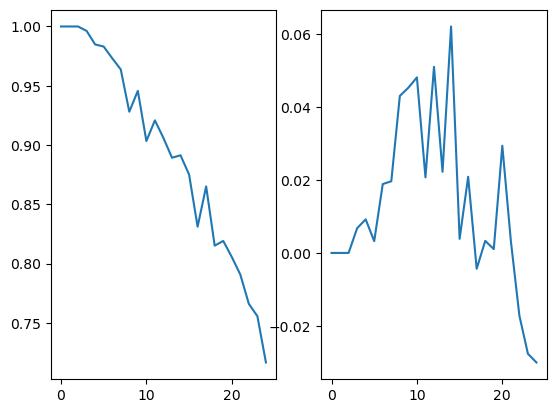

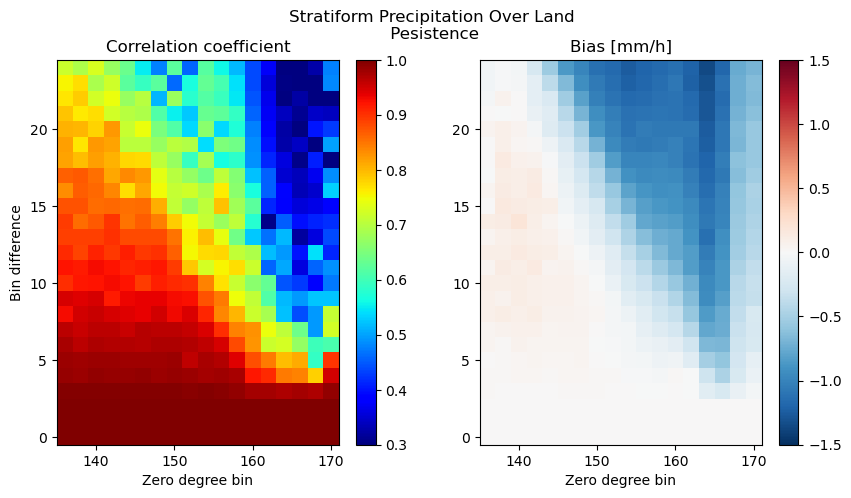

In [5]:
plt.subplot(121)
plt.plot(corrCoef)
plt.subplot(122)
plt.plot(relBias)
print(len(xL))
print(np.mean(pRateL),np.mean(pRateLL))
corrCoefL=np.array(corrCoefL)
relBiasL=np.array(relBiasL)
biasL=np.array(biasL)
print(corrCoefL.shape)
plt.figure(figsize=(10,5))
x=160-np.arange(-5,13)*2
y=np.arange(25)
plt.suptitle("Stratiform Precipitation Over Land\n Pesistence")
plt.subplot(121)
plt.pcolormesh(x,y,corrCoefL.T,cmap="jet",vmin=0.3,vmax=1)
plt.xlabel("Zero degree bin")
plt.ylabel("Bin difference")
plt.title("Correlation coefficient")
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(x,y,biasL.T,cmap="RdBu_r",vmin=-1.5,vmax=1.5)
plt.xlabel("Zero degree bin")
#plt.ylabel("Bin difference")
plt.title("Bias [mm/h]")
plt.colorbar()
plt.savefig("CorrCoefBiasLand1.png",dpi=300,bbox_inches="tight")
#plt.figure()
#plt.pcolormesh(x,y,1/(1+relBiasL).T,cmap="jet",vmin=0.1,vmax=2)
#corrFactor=1/(1+relBiasL)
#print(corrFactor.shape)
#np.savetxt("corrFact.txt",corrFactor)

In [8]:
# import knn regression from sklearn
from sklearn.neighbors import KNeighborsRegressor
# create knn model

# split the data into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, ind_train, ind_test = train_test_split(xL, range(len(xL)), test_size=0.5, random_state=42)
# fit the model
y_train=[pRateL_all[i] for i in ind_train]
y_test=[pRateL_all[i] for i in ind_test]


In [9]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(984642, 29)
(984642,)
(984642, 29)
(984642,)


In [10]:
print(np.corrcoef(X_train[:,-2],y_train))
print(np.mean(X_train[:,-2]),np.mean(y_train))
print(np.mean(X_test[:,-1]),np.mean(y_test))

[[1.         0.73639833]
 [0.73639833 1.        ]]
1.1067988118979624 1.54143003317322
1.542753660937225 1.5435314660426953


In [303]:

#knn.fit(X_train, y_train)
# predict the response
#pred = knn.predict(X_test)
# evaluate accuracy
from sklearn.metrics import mean_squared_error
#print(mean_squared_error(y_test, pred))
#print(np.corrcoef(y_test, pred))
#print(np.mean(y_test),np.mean(pred))

1.398743650253775
[[1.         0.78073487]
 [0.78073487 1.        ]]
1.5435314660426953 1.5379169219461377


In [21]:
knn = KNeighborsRegressor(n_neighbors=15, weights='distance')
knn.fit(X_train_scaled, y_train)
# predict the response
pred = knn.predict(X_test_scaled)

In [8]:
import faiss
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
index = faiss.index_factory(X_train_scaled.shape[1], "Flat")
index.train(X_train_scaled)
index.add(X_train_scaled)

y_pred_faiss=[]
import tqdm
#for x1 in tqdm.tqdm(X_test_scaled[]):
#d1,i=index.search(X_test_scaled[:1000,:], 15)
#y_pred_faiss.append(y_train[i].mean())
#break

#

In [10]:
d,i=index.search(X_test_scaled[:,:], 15)

In [11]:
y_pred_faiss=[]
for i1 in tqdm.tqdm(range(len(X_test_scaled))):
    y_pred_faiss.append(y_train[i[i1]].mean())

100%|██████████| 984642/984642 [00:02<00:00, 424103.00it/s]


In [309]:
print(X_test_scaled.shape)
res=index.search(X_test_scaled.astype(np.float32), 15)

(984642, 29)


In [213]:
print(np.corrcoef(pRateLL_all,pRateL_all))
print(np.mean(pRateLL_all),np.mean(pRateL_all))
X_test=np.array(X_test)
X_train=np.array(X_train)
#print(X_test.mean(axis=0))
#print(X_train.shape)

[[1.         0.73539447]
 [0.73539447 1.        ]]
1.1072825544641836 1.5424807496079576


In [11]:
#clut_unrolled_L=np.array(clut_unrolled_L)
clut_unrolled_L2=[]
for i in range(len(clut_unrolled_L)):
    clut_unrolled_L2.extend(clut_unrolled_L[i])
clut_unrolled_L2=np.array(clut_unrolled_L2)
print(clut_unrolled_L2.shape)
classL=np.array(classL)
print(classL.shape)


(1969284,)
(1969284,)


In [12]:
classL_test=classL[ind_test]
clut_unrolled_L2_test=clut_unrolled_L2[ind_test]


In [13]:
y_pers=np.array([pRateLL_all[i] for i in ind_test])
print((y_test[:]-y_pers).std())
y_test=np.array(y_test)[:]
#y_pred=np.array(y_pred_faiss)[:,np.newaxis]
corrCoeff_test=np.zeros((18,25),np.float32)
relBias_test=np.zeros((18,25),np.float32)
bias_test=np.zeros((18,25),np.float32)
for i in range(18):
    for j in range(25):
        ind=(classL_test==i-5)&(clut_unrolled_L2_test==j)
        corrCoeff_test[i,j]=np.corrcoef(y_test[ind], y_pred[ind])[0,1]
        relBias_test[i,j]=(y_pred[ind].mean()-y_test[ind].mean())/y_test[ind].mean()
        bias_test[i,j]=(y_pred[ind].mean()-y_test[ind].mean())

1.3086046153807984


In [23]:
print(len(y_test))

984642


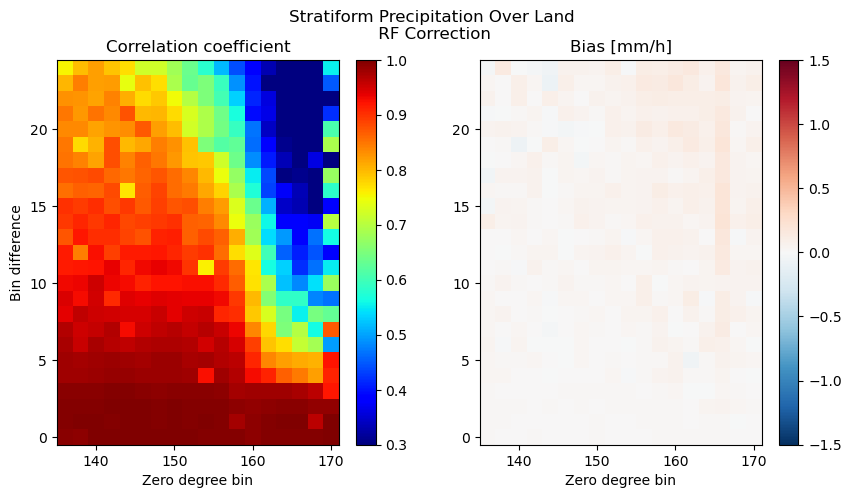

In [20]:
plt.figure(figsize=(10,5))
x=160-np.arange(-5,13)*2
y=np.arange(25)
plt.suptitle("Stratiform Precipitation Over Land\n RF Correction")
plt.subplot(121)
plt.pcolormesh(x,y,corrCoeff_test.T,cmap="jet",vmin=0.3,vmax=1)
plt.xlabel("Zero degree bin")
plt.ylabel("Bin difference")
plt.title("Correlation coefficient")
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(x,y,bias_test.T,cmap="RdBu_r",vmin=-1.5,vmax=1.5)
plt.xlabel("Zero degree bin")
#plt.ylabel("Bin difference")
plt.title("Bias [mm/h]")
plt.colorbar()
plt.savefig("CorrCoefBiasLand_ML.png",dpi=300,bbox_inches="tight")

In [27]:
print((y_test-y_pred).mean()/y_test.mean())

-0.027710329774002746


1.3791058599698778
1.5899249656490597
1.3927891987755103


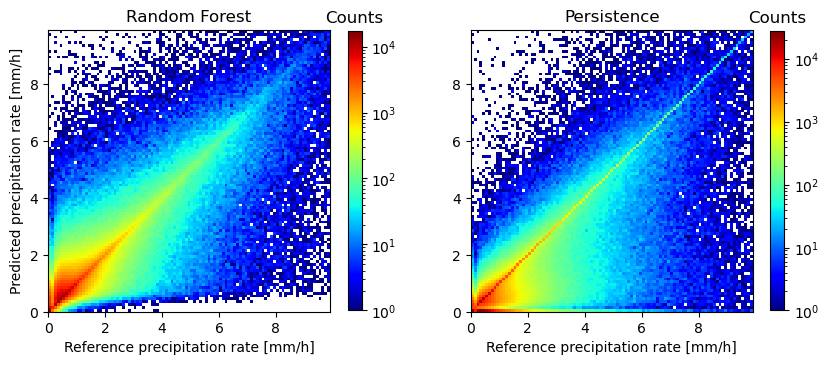

In [18]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,5))
orient="vertical"
ax1=plt.subplot(121)
hist1=plt.hist2d(y_test[:], y_pred[:], bins=(0.1*np.arange(100), 0.1*np.arange(100)), cmap=plt.cm.jet,norm=LogNorm())
plt.xlabel("Reference precipitation rate [mm/h]")
plt.ylabel("Predicted precipitation rate [mm/h]")
plt.title("Random Forest")
cbar1=plt.colorbar(hist1[-1],orientation=orient,shrink=0.725)
cbar1.ax.set_title("Counts")
ax1.set_aspect(1)
ax1=plt.subplot(122)
hist1=plt.hist2d(y_test[:], y_pers[:], bins=(0.1*np.arange(100), 0.1*np.arange(100)), cmap=plt.cm.jet,norm=LogNorm())
plt.xlabel("Reference precipitation rate [mm/h]")
plt.title("Persistence")
cbar2=plt.colorbar(hist1[-1],orientation=orient,shrink=0.725)
cbar2.ax.set_title("Counts")
ax1.set_aspect(1)

print(np.mean((y_test[:]-y_pers[:])**2)**0.5)
print((y_test[:]-1.39*y_pers[:]).std())
print(y_test.mean()/y_pers.mean())
plt.savefig("scatterPlotsLand.png",dpi=300,bbox_inches="tight")